# Project 3

Required libraries imported below

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

Data Generation

In [37]:
def is_dangerous(color_choices):
    if 3 in color_choices and 1 not in color_choices:
        return True
    return False

def one_hot_encode(color):
    arr = np.zeros(4)    
    arr[color-1] = 1
    return arr
    
def generate_wiring_diagram(part): #part signfies the part of the project the data is being generated for (1 or 2)
    if part != 1 and part != 2:
        print("invalid parameter values entered while calling generate_wiring_diagram(part) function, part can either be 1 or 2")
        return
    
    diagram = np.zeros((20,20,4), dtype=int) # Initializing a 20x20 blank diagram
    color_choices = [1, 2, 3, 4] # 1: Red, 2: Blue, 3: Yellow, 4: Green
    row_choices = list(range(0,20))
    col_choices= list(range(0,20))
    dangerous = False
    wire_to_cut = 0 # 0: No wire to cut, 1: Red, 2: Blue, 3: Yellow, 4: Green

    start_with_row = random.choice([True, False])
    
    if start_with_row: # True: Start with row, False: Start with column
        for i in range(4):
            if i%2 == 0:
                row = random.choice(row_choices) # Choosing a random row
                color = random.choice(color_choices) # Choosing a random color
                diagram[row, :] = one_hot_encode(color)
                row_choices.remove(row)
                color_choices.remove(color)
                if not dangerous:
                    dangerous = is_dangerous(color_choices) # checking if the diagram is dangerous based on the remaining colors
            else:
                col = random.choice(col_choices) # Choosing a random column
                color = random.choice(color_choices) # Choosing a random color
                diagram[:, col] = one_hot_encode(color)
                col_choices.remove(col)
                color_choices.remove(color)
                if i == 1 and not dangerous:
                    dangerous = is_dangerous(color_choices) # checking if the diagram is dangerous based on the remaining colors
                    
            if dangerous and i==2: # If the diagram is dangerous, the third wire placed is the one to cut
                wire_to_cut = color
                
    else:
        for i in range(4):
            if i%2 == 0:
                col = random.choice(col_choices) # Choosing a random column
                color = random.choice(color_choices) # Choosing a random color
                diagram[col, :] = one_hot_encode(color)
                col_choices.remove(col)
                color_choices.remove(color)
                if not dangerous:
                    dangerous = is_dangerous(color_choices) # checking if the diagram is dangerous based on the remaining colors
            else:
                row = random.choice(row_choices) # Choosing a random row
                color = random.choice(color_choices) # Choosing a random color
                diagram[:, row] = one_hot_encode(color)
                row_choices.remove(row)
                color_choices.remove(color)
                if i == 1 and not dangerous:
                    dangerous = is_dangerous(color_choices) # checking if the diagram is dangerous based on the remaining colors
                    
            if dangerous and i==2:
                wire_to_cut = color # If the diagram is dangerous, the third wire placed is the one to cut

    if part == 1: 
        return diagram, dangerous # If part is 1, return the diagram and whether it is dangerous or not
    elif part == 2:
        return diagram, wire_to_cut # If part is 2, return the diagram and the wire to cut
        


Memory Class to store dataset

In [38]:
# Creating a class to create our "dataset" for model training
class Memory:
    # Constructor
    def __init__(self, max_memory):
        self.max_memory = max_memory # maximum amount of samples to remember
        self.samples = [] # the samples

    # Adding a sample to memory
    def add_sample(self, diagram_vector, y):
        if [diagram_vector, y] not in self.samples: # Checking if the sample is already in memory
            self.samples.append((diagram_vector, y))
        if len(self.samples) > self.max_memory: # Removing the earliest sample if we reach maximum memory
            self.samples.pop(0)
        return len(self.samples)
    

    # Sampling the samples we have in memory
    def sample(self, no_samples): #no_samples is the number of samples you need
        if no_samples > len(self.samples):
            return random.sample(self.samples, len(self.samples))
        else:
            return random.sample(self.samples, no_samples)

In [115]:
def findConstants(diagram):
    curr = diagram
    colors = [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]
    constants = np.zeros(4) #An array that will contain the constant that represents relatively how much each wire is from its original color 
    for x in range(len(colors)): #For each color wire, we want to find the distance from edges
        found_in_row = False
        found_in_col = False
        for i in range(len(curr)): #Finds if the color wire is present as a row
            element_count = np.count_nonzero(np.all(curr[i] == colors[x], axis=1))#Finds the number of occurences of that color in that row
            if(element_count/len(curr[i]) >= 0.5):
                found_in_row = True
                constants[x] = element_count/len(curr[i]) * 100.0
                break
        if(not found_in_row):
            for i in range(len(curr[0])): # Finds if the color wire is present as a col
                element_count = np.count_nonzero(np.all(curr[:, i] == colors[x], axis=1)) # Finds the number of occurences of that color in that column
                if(element_count/len(curr) >= 0.5):
                    found_in_col = True
                    constants[x] = element_count/len(curr) * 100.0
                    break
    return np.exp(-constants/100)


Data generation for part 1

In [126]:
diagrams = 10000 #number of max diagrams to be stored in Memory class
memory = Memory(diagrams) #more than diagrams and the oldest diagram stored will be removed
diagram_arr = []
training_size = 5000
testing_size = 5000
for i in range(diagrams):
    diagram, y = generate_wiring_diagram(1) #type:ignore
    memory.add_sample(diagram, int(y))
samples = memory.sample(training_size+testing_size)
training_data = samples[:training_size]
testing_data = samples[training_size:]

Feature Creation

In [127]:

x_train = []
y_train = []
x_test = []
y_test = []
for diagram in training_data:
    additional_features = findConstants(diagram[0])
    x_train.append(np.concatenate(([1], diagram[0].flatten(), additional_features))) #A vector with each component being a vector of the each sample diagram's features
    y_train.append(diagram[1])
for diagram in testing_data:
    additional_features = findConstants(diagram[0])
    x_test.append(np.concatenate(([1], diagram[0].flatten(), additional_features))) #A vector with each component being a vector of the each sample diagram's features
    y_test.append(diagram[1])


Model for Part 1

Epoch:  0 Loss:  0.2748750655073473
Epoch:  1 Loss:  0.24316770372548513
Epoch:  2 Loss:  0.23632697646423234
Epoch:  3 Loss:  0.2298023393447461
Epoch:  4 Loss:  0.22367663372635066
Epoch:  5 Loss:  0.21793451236375244
Epoch:  6 Loss:  0.21255429222875
Epoch:  7 Loss:  0.20751459560105745
Epoch:  8 Loss:  0.20279447807140583
Epoch:  9 Loss:  0.19837361297687778
Epoch:  10 Loss:  0.1942324649109705
Epoch:  11 Loss:  0.19035241237714878
Epoch:  12 Loss:  0.18671582228195946
Epoch:  13 Loss:  0.18330608396177786
Epoch:  14 Loss:  0.18010761074147505
Epoch:  15 Loss:  0.17710581707188033
Epoch:  16 Loss:  0.17428707894337458
Epoch:  17 Loss:  0.17163868435655122
Epoch:  18 Loss:  0.16914877934432743
Epoch:  19 Loss:  0.16680631367728993
Epoch:  20 Loss:  0.1646009891201115
Epoch:  21 Loss:  0.16252321197368153
Epoch:  22 Loss:  0.160564050617765
Epoch:  23 Loss:  0.15871519788182425
Epoch:  24 Loss:  0.15696893739039014
Epoch:  25 Loss:  0.15531811263775294
Epoch:  26 Loss:  0.15375609748

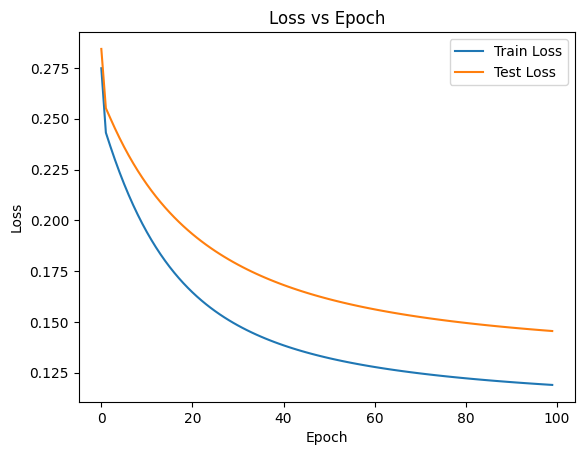

[ 5.60613097e-03 -9.42159138e-03 -5.76142128e-01 ...  9.94551030e-02
 -1.03414753e+01  3.17037894e-01]


In [124]:
class LogisticRegressionModel():
    def __init__(self, weights, alpha, epochs, lambdaVar):
        self.weights = weights
        self.alpha = alpha
        self.epochs = epochs
        self.train_loss_history = []
        self.test_loss_history = []
        self.lambdaVar = lambdaVar

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def log(self, x):
        return np.log10(x)

    def costFunction (self, features, y): #Loss Function
        loss = -1 * y * self.log(self.sigmoid(np.dot(self.weights, features)) - (1-y) * self.log(self.sigmoid(1-np.dot(self.weights, features))))
        return loss

    def gradientDescent(self, features, weights, alpha, y):
        regularization = np.dot(self.lambdaVar / len(weights), np.concatenate(([0], weights[1:])))    
        gradient = np.zeros(len(weights))
        func = self.sigmoid(np.dot(features, self.weights))
        gradient = np.dot((func - y), features) + regularization
        self.weights = self.weights - alpha * gradient
        #print("Gradient: ", gradient)
        #print("Regularization: ", regularization)
        #print(self.weights)

    def fit(self, weights, alpha, x_train, y_train, x_test, y_test, epochs):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        for epoch in range(epochs): #Epochs
            regularization = self.lambdaVar / (2 * len(weights)) * np.sum(weights[1:]**2) #L2 Regularization
            for j in range(len(x_train)): #Loop through each sample in the dataset
                self.gradientDescent(self.x_train[j], self.weights, self.alpha, self.y_train[j]) 
            loss_train = 0
            for x in range(len(x_train)): #Calculate the loss for the training data
                loss_train+=self.costFunction(self.x_train[x], self.y_train[x])
            loss_train /= len(self.x_train)
            loss_train+=regularization
            self.train_loss_history.append(loss_train)
            loss_test = 0 
            for x in range(len(x_test)): #Calculate the loss for the testing data
                loss_test+=self.costFunction(self.x_test[x], self.y_test[x])
            loss_test /= len(self.x_test)
            loss_test+=regularization
            self.test_loss_history.append(loss_test)
            
            print("Epoch: ", epoch, "Loss: ", loss_train)
        self.plot_loss(self.train_loss_history, self.test_loss_history)
        print(self.weights)

    
    def predict(self, X): #Check if this method works correctly!!!!!!!!!!!!!!!!!!!!!!!!!!
        A = np.empty(len(X))
        for i in range(len(X)):
            z = np.dot(X[i], self.weights)
            A[i] = self.sigmoid(z)
        return np.round(A)


    def plot_loss(self, train_loss, test_loss): #Plot the Epochs vs both Training and Testing Loss Curves
        plt.plot(train_loss, label="Train Loss")
        plt.plot(test_loss, label="Test Loss")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss vs Epoch')
        plt.legend()
        plt.show()   
        
    #saving and loading the model
    def save_model(self, name):
        np.savez(name, weights = self.weights)
         

weights = np.random.randn(len(x_train[0])) #Randomize weights
alpha = 0.01 # Represents step-size
epochs = 100 #Number of times you loop through the training set 
lambdaVariable = 0.15
model = LogisticRegressionModel(weights, alpha, epochs, lambdaVariable)
model.fit(weights, alpha, x_train, y_train, x_test, y_test, epochs)

In [125]:
predictions = model.predict(x_test) 

correct_predictions = np.sum(predictions == y_test)
print(correct_predictions)
accuracy = (correct_predictions / np.array(y_test).shape[0])*100
print(f"Accuracy on test set: {accuracy}")


4196
Accuracy on test set: 83.91999999999999


In [ ]:
model.save_model("model_non_linear.npz")

Data generation for part 2

In [88]:
diagrams = 6000 #number of max diagrams to be stored in Memory class
train_size = 5000 #number of samples to be generated
test_size = 1000 #number of samples to be used for testing
memory = Memory(diagrams) #more than diagrams and the oldest diagram stored will be removed

#generating 5000 diagrams and storing them in memory
len_samples = 0
while len_samples!=diagrams:
    diagram, y = generate_wiring_diagram(2) #type:ignore
    if y != 0:
        len_samples = memory.add_sample(diagram, y)
samples = memory.sample(train_size+test_size)

train_samples = samples[:train_size]
test_samples = samples[train_size:]

diagram_arr = []
y_arr = []
for diagrams, y in train_samples:
    diagram_arr.append(diagrams)
    y_arr.append(y)
    
test_diagram_arr = []
test_y_arr = []    
for test_diagrams, test_y in test_samples:
    test_diagram_arr.append(test_diagrams)
    test_y_arr.append(test_y)

y_arr = np.array(y_arr) #converting the y_arr to a numpy array for easier computation
test_y_arr = np.array(test_y_arr) #converting the test_y_arr to a numpy array for easier computation

Data Processing

In [61]:
def process_data_part2(diagram_arr, y_arr):
    
    flattened_diagrams = np.array([diagram.flatten() for diagram in diagram_arr])
    
    #generate additional features
    sum_of_pixels = np.array([diagram.sum(axis=(0, 1)) for diagram in diagram_arr])
    additional_features = np.abs(np.subtract(sum_of_pixels, 19))
    additional_features = np.square(np.add(additional_features,2))
    
    #some more additional features
    positions = np.where(sum_of_pixels == 19)[1].reshape(-1,2) #finding what color of wire contains 19 pixels
    e_vector = np.eye(4)[positions]
    new_vector = []
    row = 0
    col = 0
    for i in range(len(diagram_arr)):
        for j in range(2):
            indices = np.where(np.all(diagram_arr[i] == e_vector[i][j], axis = 2))
            if indices[0][0] == indices[0][1]:
                row = indices[0][0]
            elif indices[1][0] == indices[1][1]:
                col = indices[1][0]
        for j in range(2):
            if tuple(e_vector[i][j]) == tuple(diagram_arr[i][row][col]):
                new_vector.append(1)
            else:
                new_vector.append(0)
                
    new_vector = np.array(new_vector).reshape(-1,2)
    new_vector = np.square(np.exp(new_vector))
    
    X_combined = np.concatenate((flattened_diagrams, additional_features, new_vector), axis=1)
    X = np.c_[X_combined, np.ones(X_combined.shape[0])]
    Y = np.eye(4)[np.subtract(y_arr,1)]
    
    return X, Y

In [93]:
X_train, Y_train = process_data_part2(diagram_arr, y_arr)
X_test, Y_test = process_data_part2(test_diagram_arr, test_y_arr)

print(f"X_train shape: {X_train.shape}")
print(f"First 5 element of X_train:\n{X_train[:5]}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Frist 5 element of Y_train:\n{Y_train[:5]}")
print()

print(f"X_test shape:{X_test.shape}")
print(f"First 5 element of X_test:\n{X_test[:5]}")
print(f"Y_test shape: {Y_test.shape}")
print(f"First 5 element of Y_test:\n{Y_test[:5]}")

X_train shape: (5000, 1607)
First 5 element of X_train:
[[0.        0.        0.        ... 1.        7.3890561 1.       ]
 [0.        0.        0.        ... 1.        7.3890561 1.       ]
 [0.        0.        0.        ... 1.        7.3890561 1.       ]
 [0.        0.        0.        ... 1.        7.3890561 1.       ]
 [0.        0.        0.        ... 1.        7.3890561 1.       ]]
Y_train shape: (5000, 4)
Frist 5 element of Y_train:
[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

X_test shape:(1000, 1607)
First 5 element of X_test:
[[0.        0.        0.        ... 1.        7.3890561 1.       ]
 [0.        0.        0.        ... 7.3890561 1.        1.       ]
 [0.        0.        0.        ... 7.3890561 1.        1.       ]
 [0.        0.        0.        ... 7.3890561 1.        1.       ]
 [0.        0.        0.        ... 7.3890561 1.        1.       ]]
Y_test shape: (1000, 4)
First 5 element of Y_test:
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 

Part 2 implementation

In [94]:
#defining the softmax function
def softmax(x): 
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

class Model():
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.epsilon = 1e-10
        self.regularization = 0.01
        self.train_loss_history = []
        self.test_loss_history = []
        
    def fit(self, X_train, Y_train, X_test, Y_test, learning_rate = 0.001, epochs = 10):
        m = X_train.shape[0]
        for epoch in range(epochs):
            
            #forward propagation for training
            Z_train = np.dot(X_train, self.W) + self.b
            A_train = softmax(Z_train)
            
            loss_train = -np.mean(np.sum(Y_train * np.log(A_train + self.epsilon), axis=1)) #calculating the loss
            loss_train += 0.5 * self.regularization * np.sum(self.W ** 2) #calculating the regularization loss
            
            self.train_loss_history.append(loss_train)
            
            # Forward pass for test data
            Z_test = np.dot(X_test, self.W) + self.b
            A_test = softmax(Z_test)
            
            loss_test = -np.mean(np.sum(Y_test * np.log(A_test + self.epsilon), axis=1))
            loss_test += 0.5 * self.regularization * np.sum(self.W ** 2)
            self.test_loss_history.append(loss_test)
            
            #calculating the gradients
            dW = (1/m) * np.dot(X_train.T, (A_train-Y_train)) + (self.regularization * self.W)
            db = (1/m) * np.sum(A_train-Y_train, axis=0) + (self.regularization * self.b)
            
            #updating the weights and biases
            self.W -= learning_rate * dW 
            self.b -= learning_rate * db
            
            print("Epoch: ", epoch, "Loss: ", loss_train)
        
        self.plot_loss(self.train_loss_history, self.test_loss_history)

    def predict(self, X): #prediction function
        Z = np.dot(X, self.W) + self.b
        probs = softmax(Z)
        return np.argmax(probs, axis=1) + 1
    
    #plotting the loss
    def plot_loss(self, train_loss_history, test_loss_history):
        plt.plot(train_loss_history, label = "train loss")
        plt.plot(test_loss_history, label = "test loss")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss vs Epoch')
        plt.legend()
        plt.show()
    
    #saving and loading the model
    def save_model(self, name):
        np.savez(name, W=self.W, b=self.b)
        
    def load_model(self, name):
        loaded_data = np.load(name)
        self.W = loaded_data['W']
        self.b = loaded_data['b']

In [95]:
num_classes = 4
num_features = X_train.shape[1]
W = np.random.rand(num_features, num_classes)
b = np.zeros(num_classes)
model = Model(W, b)

In [ ]:
model.load_model('model_non_linear.npz')  # Load weights from a saved file

Epoch:  0 Loss:  13.916361706073708
Epoch:  1 Loss:  13.385997377033446
Epoch:  2 Loss:  13.096585129286954
Epoch:  3 Loss:  12.870144784647913
Epoch:  4 Loss:  12.681126038963015
Epoch:  5 Loss:  12.540121552689014
Epoch:  6 Loss:  12.403419082632194
Epoch:  7 Loss:  12.291679770663993
Epoch:  8 Loss:  12.155330807582828
Epoch:  9 Loss:  12.031954442760169
Epoch:  10 Loss:  11.897606384738754
Epoch:  11 Loss:  11.7757662917649
Epoch:  12 Loss:  11.661131413662973
Epoch:  13 Loss:  11.557624811737911
Epoch:  14 Loss:  11.466843085945094
Epoch:  15 Loss:  11.386412017418664
Epoch:  16 Loss:  11.316765585299358
Epoch:  17 Loss:  11.254919617432542
Epoch:  18 Loss:  11.199674507331451
Epoch:  19 Loss:  11.149055910320586
Epoch:  20 Loss:  11.101986232645677
Epoch:  21 Loss:  11.057590816076585
Epoch:  22 Loss:  11.015364139150453
Epoch:  23 Loss:  10.974966938074207
Epoch:  24 Loss:  10.936171550357612
Epoch:  25 Loss:  10.898806222810245
Epoch:  26 Loss:  10.862732181605136
Epoch:  27 Lo

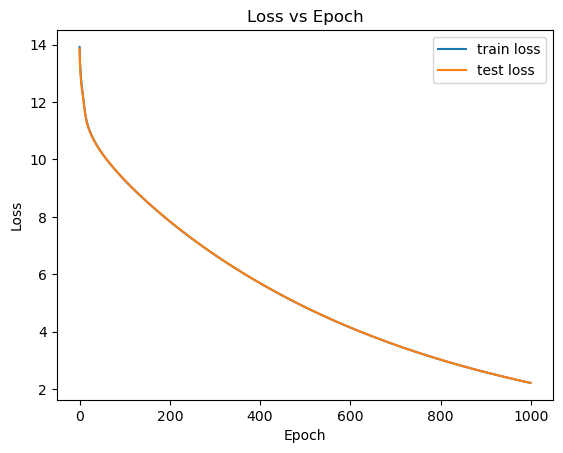

In [96]:
#training the model
model.fit(X_train, Y_train, X_test, Y_test, learning_rate=0.08, epochs = 1000)

In [97]:
predictions = model.predict(X_test)

correct_predictions = np.sum(predictions == test_y_arr)
print(correct_predictions)
accuracy = (correct_predictions / Y_test.shape[0])*100
print(f"Accuracy on test set: {accuracy}")


1000
Accuracy on test set: 100.0


In [98]:
predictions = model.predict(X_train)

correct_predictions = np.sum(predictions == y_arr)
print(correct_predictions)
accuracy = (correct_predictions / Y_train.shape[0])*100
print(f"Accuracy on training set: {accuracy}")


5000
Accuracy on training set: 100.0


In [ ]:
model.save_model("model_non_linear.npz")